# Data Analyst Professional Practical Exam Submission

**You can use any tool that you want to do your analysis and create visualizations. Use this template to write up your summary for submission.**

You can use any markdown formatting you wish. If you are not familiar with Markdown, read the [Markdown Guide](https://s3.amazonaws.com/talent-assets.datacamp.com/Markdown+Guide.pdf) before you start.


## Data Validation

The dataset has 15000 rows and 8 columns. The following columns are validated:

1. week - Numeric datatype without null values and values below zero. Column is clean.
2. sales_method - Character datatype without null values. Column has 5 unique values due to inconsistent capitalization and abbreviation. Column is cleaned by replacing the inconsistencies to the expected 3 unique values (Call, Email, Email + Call)
3. customer_id - Character datatype without null values, each value is unique. Column is clean.
4. nb_sold - Numeric datatype without null values and values below zero. Column is clean.
5. revenue - Numeric datatype rounded to two decimal places with null values. The column is cleaned by creating a linear regression model per sales method using the numbers sold as the independent variable (very strong correlation with revenue grouped per sales method) that predicts the revenue value that will be imputed.
6. years_as_customer - Numeric datatype without null values and values below zero. There are values that exceeds the years that the company has existed. The column is cleaned by replacing the invalid years to their probable values based on typographical error.
7. nb_site_visits - Numeric datatype without null values and values below zero. Column is clean.
8. state - Character datatype without null values, 50 unique values. Column is clean.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

df = pd.read_csv('product_sales.csv')
df

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois
...,...,...,...,...,...,...,...,...
14995,4,Call,17267b41-d048-4346-8b90-7f787690a836,10,50.82,0,22,Pennsylvania
14996,5,Call,09e10d6f-4508-4b27-895e-4db11ce8302b,10,52.33,1,27,Kansas
14997,1,Call,839653cb-68c9-48cb-a097-0a5a3b2b298b,7,34.87,4,22,West Virginia
14998,6,Call,e4dad70a-b23b-407c-8bd3-e32ea00fae17,13,64.90,2,27,New Jersey


In [2]:
def col_check(col):
    print('column: {}'.format(col))
    print('number of missing values: {}'.format(df[col].isnull().sum()))
    print('number of unique values: {}'.format(df[col].nunique()))
    print('unique values: {}'.format(df[col].unique()))
    print('\n')
    
print(df.info(), '\n')    
for col in df.columns:
    col_check(col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB
None 

column: week
number of missing values: 0
number of unique values: 6
unique values: [2 6 5 4 3 1]


column: sales_method
number of missing values: 0
number of unique values: 5
unique values: ['Email' 'Email + Call' 'Call' 'em + call' 'email']


column: customer_id
number of missing values: 0
number of unique values: 15000
unique values: ['2

Columns with problems:
- sales_method: inconsistent capitalization and abbreviation
- revenue: null values
- years_as_customer: higher years compared to the years that the company has existed.

In [3]:
method_map = {'em + call':'Email + Call',
              'email':'Email'}

df['sales_method'] = df['sales_method'].replace(method_map)
df['sales_method'].unique()

array(['Email', 'Email + Call', 'Call'], dtype=object)

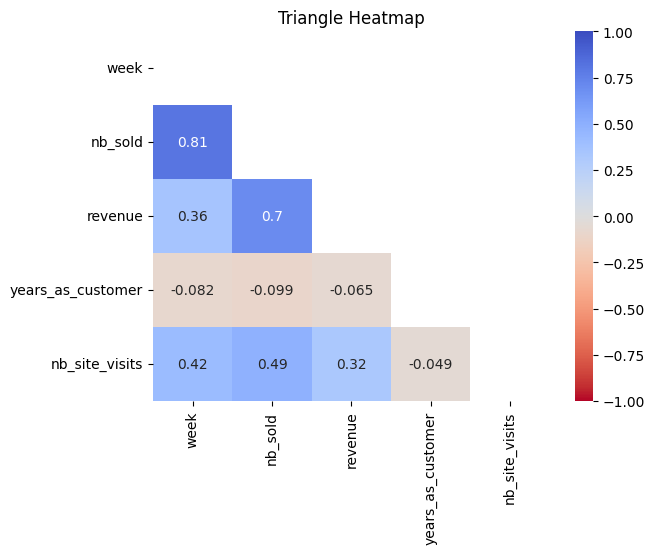

In [4]:
nums = df.select_dtypes(include=np.number)
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), cmap='coolwarm_r', annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Triangle Heatmap')
plt.show()

Since numbers sold has a strong correlation with revenue, this is a good predictor for the null values of the revenue. Numbers sold vs revenue is plotted to have a better idea of the relationship

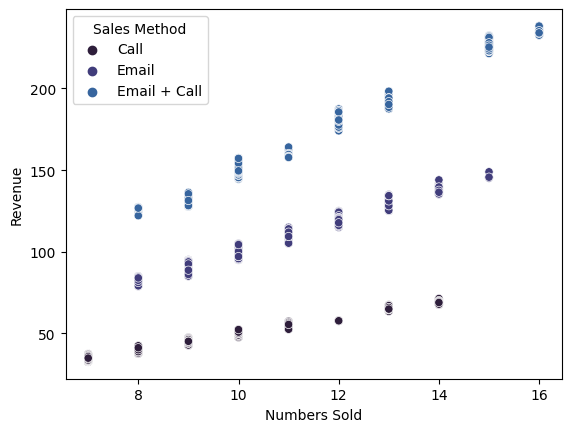

In [5]:
sns.set_palette('mako')
color_order = ['Call', 'Email', 'Email + Call']

sns.scatterplot(x='nb_sold', y='revenue', data=df, hue='sales_method', hue_order=color_order)
plt.legend(title='Sales Method')
plt.xlabel('Numbers Sold')
plt.ylabel('Revenue')
plt.show()

Based on the graph, there are different slopes for each sales method. The correlation is computed for each dataframe with a single sales method.

In [6]:
call_df = df[df['sales_method'] == 'Call']
email_df = df[df['sales_method'] == 'Email']
email_call_df = df[df['sales_method'] == 'Email + Call']

sales_dfs = {'Call':call_df, 'Email':email_df, 'Email + Call':email_call_df}
for method, dataframe in sales_dfs.items():
    print('corr for {}: {}'.format(method, dataframe['revenue'].corr(dataframe['nb_sold'])))

corr for Call: 0.9858796014324887
corr for Email: 0.9678431333077845
corr for Email + Call: 0.989590747897073


Since there is a really strong correlation for each dataframe, the numbers sold for each dataframe will be used to impute null values.

In [7]:
def create_model(dataframe):
    dataframe.dropna(inplace=True)
    X = np.array(dataframe['nb_sold']).reshape(-1,1)
    y = np.array(dataframe['revenue'])
    return LinearRegression().fit(X, y)
    
call_model = create_model(call_df)
email_model = create_model(email_df)
email_call_model = create_model(email_call_df)

In [8]:
null_index = df[df['revenue'].isna()].index

df.loc[(df['revenue'].isna()) & (df['sales_method'] == 'Call'), 'revenue'] = call_model.predict(np.array(df[(df['revenue'].isna()) & (df['sales_method'] == 'Call')]['nb_sold']).reshape(-1,1))

df.loc[(df['revenue'].isna()) & (df['sales_method'] == 'Email'), 'revenue'] = email_model.predict(np.array(df[(df['revenue'].isna()) & (df['sales_method'] == 'Email')]['nb_sold']).reshape(-1,1))

df.loc[(df['revenue'].isna()) & (df['sales_method'] == 'Email + Call'), 'revenue'] = email_call_model.predict(np.array(df[(df['revenue'].isna()) & (df['sales_method'] == 'Email + Call')]['nb_sold']).reshape(-1,1))

In [9]:
df['revenue'] = df['revenue'].round(2)
df.iloc[null_index]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,99.67,0,24,Arizona
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,108.87,3,25,Indiana
16,2,Email,0f744f79-1588-4e0c-8865-fdaecc7f6dd4,10,99.67,6,30,Pennsylvania
17,6,Email + Call,d10690f0-6f63-409f-a1da-8ab0e5388390,15,225.57,0,24,Wisconsin
28,5,Email,f64f8fd5-e9b7-4326-9f5d-ef283f14d7ad,12,118.07,4,32,Florida
...,...,...,...,...,...,...,...,...
14951,5,Call,5f1c099a-3cf2-4c32-91f0-5ec802926073,10,50.04,10,25,Virginia
14957,1,Call,b7947946-8b0a-4031-8835-226200f260a5,7,35.34,5,23,Illinois
14970,4,Email + Call,72be03aa-25b1-4574-b358-74118cd8d81a,12,180.87,12,25,Washington
14992,5,Email + Call,cd9e6945-ae21-4bed-a6cf-f0302e6c4795,12,180.87,1,34,New York


All null values have been replaced with their respective linear models.

In [10]:
max_years = 2023 - 1984
invalid_years = df[df['years_as_customer'] > max_years].index
df.iloc[invalid_years]

Since the max number of years is 39, it seems most likely that the numbers in 63 is supposed to be 36 but was interchanged due to typo. Likely values from 47 is either 36 by shifting to the left from the keyboard or 14 by shifting downwards from the numpad. For simplicity, both is replaced with 36.

In [11]:
df.loc[df['years_as_customer'] > max_years, 'years_as_customer'] = 36
df.iloc[invalid_years]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,36,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,36,27,California


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            15000 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


## Exploratory Analysis

### 1. How many customers were there for each approach?

As expected, email has the highest number of sales with 7466 sales since this is the easiest of the three. This is followed by call with 4962 sales and lastly by email plus call with 2572 sales.

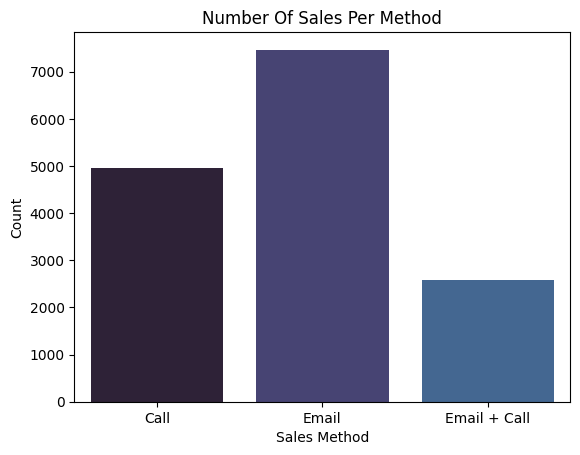

Email           7466
Call            4962
Email + Call    2572
Name: sales_method, dtype: int64


In [13]:
sns.countplot(x='sales_method', data=df, order=color_order)
plt.title('Number Of Sales Per Method')
plt.xlabel('Sales Method')
plt.ylabel('Count')
plt.show()

print(df['sales_method'].value_counts())

### 2. What does the spread of the revenue look like overall? And for each method?

The total revenue has multiple peaks, this is explained by multiple median values in the distribution per sales method. Email plus call has the highest amount of revenue but also has the highest variance. Email generates a respectable amount of revenue for the work it requires. Call on the other hand requires the highest amount of time yet produces the least amount of revenue.

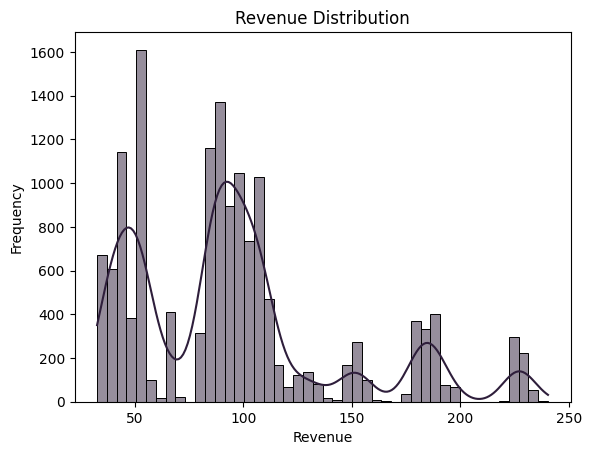

In [14]:
sns.histplot(x='revenue', data=df, kde=True)
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

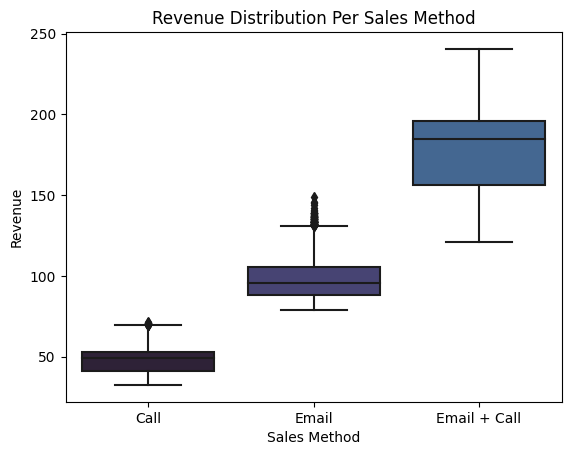

In [15]:
sns.boxplot(x='sales_method', y='revenue', data=df, order=color_order)
plt.title('Revenue Distribution Per Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Revenue')
plt.show()

### 3. Was there any difference in revenue overtime for each of the methods?

Each method increases overtime but the increase rate are different. Email plus call has the highest increase rate and is significantly different compared to the other two. Email has a higher increase rate compared to call, however the difference doesn't seem to be significant.

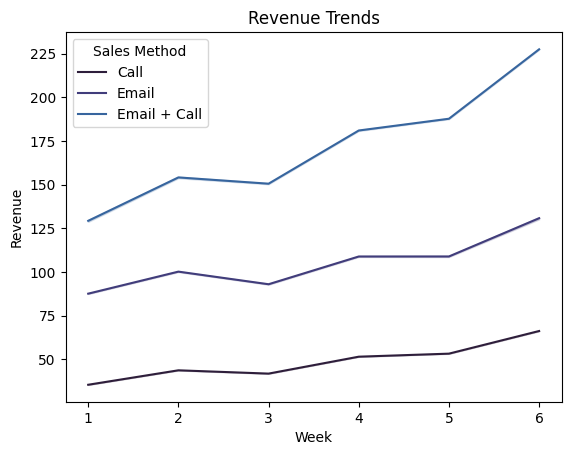

In [16]:
sns.lineplot(x='week', y='revenue', data=df, hue='sales_method', hue_order=color_order)
plt.title('Revenue Trends')
plt.legend(title='Sales Method')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.show()

### 4. Based on the data, which method would you recommend we continue to use? Some of these methods take more time from the team so they may not be the best for us if the results are similar.

I would recommend to discontinue in using the call method since it yields the least amount of revenue and requires the most amount of time among the sales methods performed. If time is a limiting factor, it would be best to continue to use the email method since it takes the least amount of work while having a higher revenue than call. However, it would be best to prioritize the email plus call method since it yields the highest amount of revenue for a moderate amount of work.

By exploring the relationship of other variables with revenue. To maximize profits, I would also recommend to target customers with high number of site visits and products that has a higher week count since product launch.

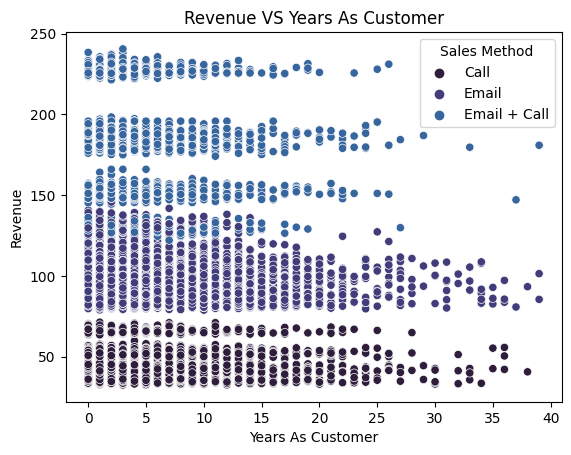

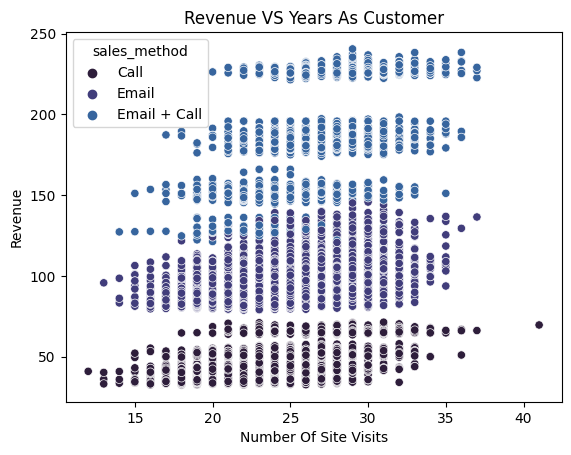

In [17]:
sns.scatterplot(x='years_as_customer', y='revenue', data=df, hue='sales_method', hue_order=color_order)
plt.title('Revenue VS Years As Customer')
plt.legend(title='Sales Method')
plt.xlabel('Years As Customer')
plt.ylabel('Revenue')
plt.show()

sns.scatterplot(x='nb_site_visits', y='revenue', data=df, hue='sales_method', hue_order=color_order)
plt.title('Revenue VS Years As Customer')
plt.xlabel('Number Of Site Visits')
plt.ylabel('Revenue')
plt.show()

## Business Metric

It is recommended to use the **average revenue per customer** from the past six weeks as the key performance indicator which is **equal to 95.72**. Using the data from the past six weeks, the revenue is expected to increase by **2.5 million** assuming the same workload and all calls are effectively replaced by email plus call. The **KPI is expected to reach 262.79** based on the projection of revenue increase.

Calculations is shown in the appendix.

## Recommendations

For the following weeks:
- Closely inspect KPI when changing sales methods.
    - If replacing call method only with email plus call yields a significant increase, proceed with the change.
    - Otherwise, proceed to gather additional data regarding product type since it was said that the best approach may vary per product.
- Target customers with high number of site visits and products with high number of weeks since product launch when using email plus call to maximize revenue.
- Additional data for further analysis.
    - Add product type when gathering data to identify which method is most effective for that product type.
    - Include the amount of time spent to compute for the efficiency of each method by comparing the time spent with revenue outcome.

## Appendix

In [18]:
print('average revenue per customer: {}'.format(df['revenue'].mean()))

calls = len(df[df['sales_method'] == 'Call'])
email_call = calls * 3
rev_inc = (email_call * df[df['sales_method'] == 'Email + Call']['revenue'].mean()) - (calls * df[df['sales_method'] == 'Call']['revenue'].mean())

projected_rev = df['revenue'].sum() + rev_inc
rev_per_customer = projected_rev / len(df)


print('estimated revenue increase: {}'.format(rev_inc))
print('projected revenue per customer: {}'.format(rev_per_customer))


average revenue per customer: 95.72087733333335
estimated revenue increase: 2506053.0670917574
projected revenue per customer: 262.7910818061172


## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation